In [1]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from cliffs_delta import cliffs_delta

from ecoselekt.settings import settings

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [2]:
EXP_ID = "apch"
MODEL_HISTORY = 15

PROJECTS = [
    "activemq",
    "camel",
    "cassandra",
    "flink",
    "groovy",
    "hbase",
    "hive",
    "ignite",
]

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
all_latency_df = pd.DataFrame(columns=["project", "window", "commit_id", "eco_pred_time", "base_pred_time"])
for project in PROJECTS:
    latency_df = pd.read_csv(DATA_DIR / f"{EXP_ID}_{project}_inf_perf_lr.csv")
    latency_df["project"] = project
    all_latency_df = pd.concat([all_latency_df, latency_df], ignore_index=True)

all_latency_df["eco_pred_time"] = all_latency_df["eco_pred_time"] * 1000
all_latency_df["base_pred_time"] = all_latency_df["base_pred_time"] * 1000

all_latency_df.head()

,project,window,commit_id,eco_pred_time,base_pred_time
0,activemq,15,014773936022e72b4f8fdff90a0f9fdc33c9b247,3.448963,2.168894
1,activemq,15,02538ed9061b1a57c1a8b0c5accff76465429da0,2.754927,1.434088
2,activemq,15,02ef3dc91846b209dbcf9b65cced501bda2d8280,3.446817,1.419067
3,activemq,15,0484af1c61ca26ce8ea7e2decf953052e0a7ad1e,5.620956,2.535105
4,activemq,15,093b0e2370ebd4c133fa2f110a39ac53dd1bb699,3.350019,1.617908


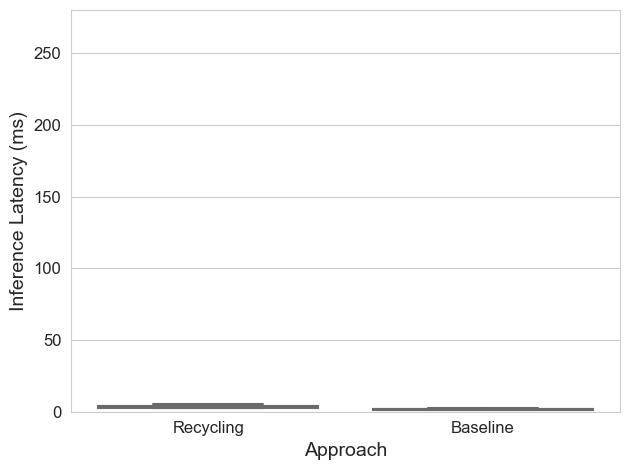

In [5]:
# plot boxplot of inference latency for both eco and base models in one plot
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(all_latency_df[["eco_pred_time", "base_pred_time"]].rename(columns={"eco_pred_time": "Recycling", "base_pred_time": "Baseline"})),
    palette="Set3",
    showfliers=False,
)
# start from 0 y-axis
p.set_ylim(0, 280)
# increase font size
p.tick_params(labelsize=12)
p.set_xlabel("Approach", fontsize=14)
p.set_ylabel("Inference Latency (ms)", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
ALPHA = 0.05

stat_df = pd.DataFrame(columns=["project", "significant", "effect_size"])

for project in PROJECTS:
    temp_df = all_latency_df[all_latency_df["project"] == project]
    _, p = wilcoxon(temp_df["eco_pred_time"], temp_df["base_pred_time"])
    print(f"Significant? -> {p < ALPHA}")
    res = None
    if p < ALPHA:
        d, res = cliffs_delta(temp_df["eco_pred_time"], temp_df["base_pred_time"])
        print(f"Cliff's Delta -> {d}, {res}")
    eco_med = temp_df["eco_pred_time"].median()
    base_med = temp_df["base_pred_time"].median()
    factor = eco_med / base_med
    print(f"Median factor -> {factor}")
    stat_df = stat_df.append({"project": project, "significant": p, "effect_size": res, "eco_med": eco_med, "base_med": base_med, "factor": factor}, ignore_index=True)

stat_df

Significant? -> True
Cliff's Delta -> 0.9443995, large
Median factor -> 1.96235667909928
Significant? -> True
Cliff's Delta -> 0.9375422216441207, large
Median factor -> 1.9824269050143797
Significant? -> True
Cliff's Delta -> 0.9431824375, large
Median factor -> 1.9251599464365332
Significant? -> True
Cliff's Delta -> 0.8110721779778394, large
Median factor -> 2.045959160195609
Significant? -> True
Cliff's Delta -> 0.9672194375, large
Median factor -> 2.0022477522478077
Significant? -> True
Cliff's Delta -> 0.927742438563327, large
Median factor -> 1.918212365591397
Significant? -> True
Cliff's Delta -> 0.9075497448979591, large
Median factor -> 1.9561880589799194
Significant? -> True
Cliff's Delta -> 0.938630015625, large
Median factor -> 1.960090244281935


,project,significant,effect_size,eco_med,base_med,factor
0,activemq,0.0,large,3.386855,1.725912,1.962357
1,camel,0.0,large,3.119946,1.573801,1.982427
2,cassandra,0.0,large,3.084898,1.602411,1.925160
3,flink,0.0,large,4.240155,2.072453,2.045959
4,groovy,0.0,large,2.867103,1.431942,2.002248
5,hbase,0.0,large,3.402591,1.773834,1.918212
6,hive,0.0,large,3.858924,1.972675,1.956188
7,ignite,0.0,large,3.003478,1.532316,1.960090


In [7]:
print(stat_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrlrrr}
\toprule
  project &  significant & effect\_size &  eco\_med &  base\_med &  factor \\
\midrule
 activemq &        0.000 &       large &    3.387 &     1.726 &   1.962 \\
    camel &        0.000 &       large &    3.120 &     1.574 &   1.982 \\
cassandra &        0.000 &       large &    3.085 &     1.602 &   1.925 \\
    flink &        0.000 &       large &    4.240 &     2.072 &   2.046 \\
   groovy &        0.000 &       large &    2.867 &     1.432 &   2.002 \\
    hbase &        0.000 &       large &    3.403 &     1.774 &   1.918 \\
     hive &        0.000 &       large &    3.859 &     1.973 &   1.956 \\
   ignite &        0.000 &       large &    3.003 &     1.532 &   1.960 \\
\bottomrule
\end{tabular}

